In [45]:
import librosa
import matplotlib
import scipy 
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as mplticker
from scipy.signal import lfilter
from dataclasses import dataclass

from pymatreader import read_mat
import soundfile as sf

import phast
import abt


def frequency_ax(ax = None):
    if ax is None:
        ax = plt.gca()
    ax.set_yscale("symlog", linthresh=1000.0, base=2)
    ax.yaxis.set_major_formatter(mplticker.ScalarFormatter())
    ax.yaxis.set_major_locator(mplticker.SymmetricalLogLocator(ax.yaxis.get_transform()))
    ax.yaxis.set_label_text("frequency [Hz]")
    
def time_vs_freq(ax = None):
    if ax is None:
        ax = plt.gca()
    ax.set_xlabel("time [s]")
    frequency_ax(ax)


def plot_heatmap(t, y, data, ax = None, fig=None):
    if ax is None:
        fig, ax = plt.subplots(figsize=(9, 4))
        
    img = ax.pcolormesh(
        t, y, data, cmap="inferno", vmin=data.min(), vmax=data.max()
    )
    frequency_ax(ax)
    ax.set_xlabel("time [s]")
    fig.colorbar(img, ax=ax)


def min_max_scale(data, a=-80, b=0):
    data_min = np.min(data)
    data_max = np.max(data)
    return a + (data - data_min) * (b - a) / (data_max - data_min)

def make_bins(n, data):
    return data[:, :len(data[0])//n*n].reshape(data.shape[0], -1, n).sum(axis=2)

def apply_filter(
    data: np.ndarray,
    window_type: str = "hann",
    window_size: int = 2048,
    hop_length: int = None,
    scale: bool = True,
    clip_outliers: float = 0.0,
    n_bins: int = 0,
    resample_to: int = None
):
    hop_length = hop_length or window_size // 4
    
    data = data.copy()
    if clip_outliers != 0.0:
        q99 = np.quantile(data.ravel(), clip_outliers)
        data[data > q99] = q99

    if n_bins != 0:
        data = make_bins(n_bins, data)
    
    window = scipy.signal.get_window(window_type, window_size)
    wsum = window.sum()
    data = np.vstack(
        [
            (np.convolve(data[i], window, mode="same") / wsum)[::hop_length]
             for i in range(data.shape[0])
        ]
    )
    if scale:
        data = min_max_scale(data)

    if resample_to:
        data = np.array([scipy.signal.resample(x, resample_to) for x in data])
        
    return data

@dataclass
class MatlabData:
    M: np.ndarray
    T: np.ndarray
    I_det: np.ndarray
    greenwood_f: np.ndarray
    mat: object = None
    
    pw: float = 18e-6
    
    @staticmethod
    def read(path: str, m: int = 0, scaling_factor: float = 1.1) -> "MatlabData":
        mat = read_mat(path)
        TIa = mat["Df120"]["TIa"][m] * 1e-3
        TIb = mat["Df120"]["TIb"][m] * 1e-3
        I_det = TIa + TIb 
        I_det = np.nan_to_num(I_det, nan=np.nanmax(I_det, axis=0))
        
        return MatlabData(
            M = mat['Df120']['M'][m] * scaling_factor,
            T = mat['Df120']['T'][m] * scaling_factor,
            I_det = MatlabData.transform_to_virtual(I_det),
            greenwood_f = np.flip(mat['Df120']['Fn'][m] * 1e3),
            mat=mat
        )
        
        
    @staticmethod
    def transform_to_virtual(i_det):
        reshaped = i_det[:, :i_det.shape[1] - 1, :].reshape(-1, i_det.shape[2]).T
        return np.flip(np.c_[reshaped, i_det[-1, -1, :]], axis=0)
    
    @property
    def i_det(self):
        'i_det no cs'
        return self.I_det[:, 4::8]
    
    def spatial_factor(self, fiber_idx, i_det):
        return np.nanmin(i_det, axis=0) / i_det[fiber_idx, :]

    def sigma(self, fiber_idx, i_det):
        return i_det[fiber_idx, :] * 0.06
    

def find_nearest_idx(array, value):
    array = np.asarray(array)
    idx = (np.abs(array - value)).argmin()
    return idx

def create_neurogram(fiber_stats, selected_fibers, binsize, duration):
    bins = np.arange(0, duration, binsize)
    data = np.zeros((len(selected_fibers), len(bins)))
    for i, fiber_idx in enumerate(selected_fibers):
        fs = [fs for fs in fiber_stats if fs.fiber_id == fiber_idx]
        spike_times = phast.spike_times(fs)
        idx = np.digitize(spike_times, bins)
        values, counts = np.unique_counts(idx)
        data[i, values] += counts
    return data

In [46]:
MIN_FREQ = 150
MAX_FREQ = 9350

FS = 17400
NAME = "defineit"
N_MELS = 80
N_FFT = 2048
N_HOP = N_FFT // 32
CS = False

ELECTRODE_FREQ_EDGES = [340, 476, 612, 680, 816, 952, 1088, 1292, 1564, 1836, 2176, 2584, 3060, 3604, 4284, 8024]
ELECTRODE_FREQ_CENTERS = ELECTRODE_FREQ_EDGES[:-1] + (np.diff(ELECTRODE_FREQ_EDGES) / 2)


MEL_SCALE = librosa.filters.mel_frequencies(N_MELS, fmin=MIN_FREQ, fmax=MAX_FREQ) 

MAT = MatlabData.read("Fidelity120 HC3A MS All Morphologies 18us CF.mat", scaling_factor=1)

IDET = MAT.i_det if not CS else MAT.I_det

pulse_train, audio_signal = abt.wav_to_electrodogram(
    abt.sounds[NAME], 
    current_steering=CS, 
    charge_balanced=False,  
    virtual_channels=True,
    apply_audiomixer=False,
    ramp_type = 'cs',
    M=MAT.M * 1000,
    T=MAT.T * 1000,
    Fs = FS,
    stim_db = 67,
    ramp_duration=0.1
)

audio_signal = audio_signal[0]

S = librosa.feature.melspectrogram(y=audio_signal, sr=FS, n_fft=N_FFT, hop_length=N_HOP, n_mels=N_MELS, fmin=MIN_FREQ, fmax=MAX_FREQ)
ref_db = np.max(S)

print(ref_db)
print(S.shape)

stimulus = phast.PulseTrain(pulse_train, time_step=MAT.pw)
duration = stimulus.t_max * MAT.pw
print(pulse_train.shape)
print(stimulus, duration)

# np.abs(pulse_train.max(axis=1)) / IDET.min(axis=0)

# pulse_train = pulse_train / IDET.min(axis=0).reshape(-1, 1)

# pt = pulse_train.copy()
# pt[pt == 0 ] = 100

# scaler = (IDET.min(axis=0) / (pulse_train.max(axis=1) - np.min(pt, axis=1))).reshape(-1, 1)
# pulse_train *= scaler

pulse_train.max(axis=1) / IDET.min(axis=0)


99.66173
(80, 243)
(15, 49530)
<PulseTrain n_pulses: 47879 duration : 0.891540> 0.89154


array([2.0504286 , 2.73677927, 2.47750768, 2.75331579, 2.74395487,
       2.45167106, 2.73583475, 3.17153545, 2.87740487, 2.63195364,
       2.57554162, 2.26735224, 1.94706817, 1.7932271 , 1.7553575 ])

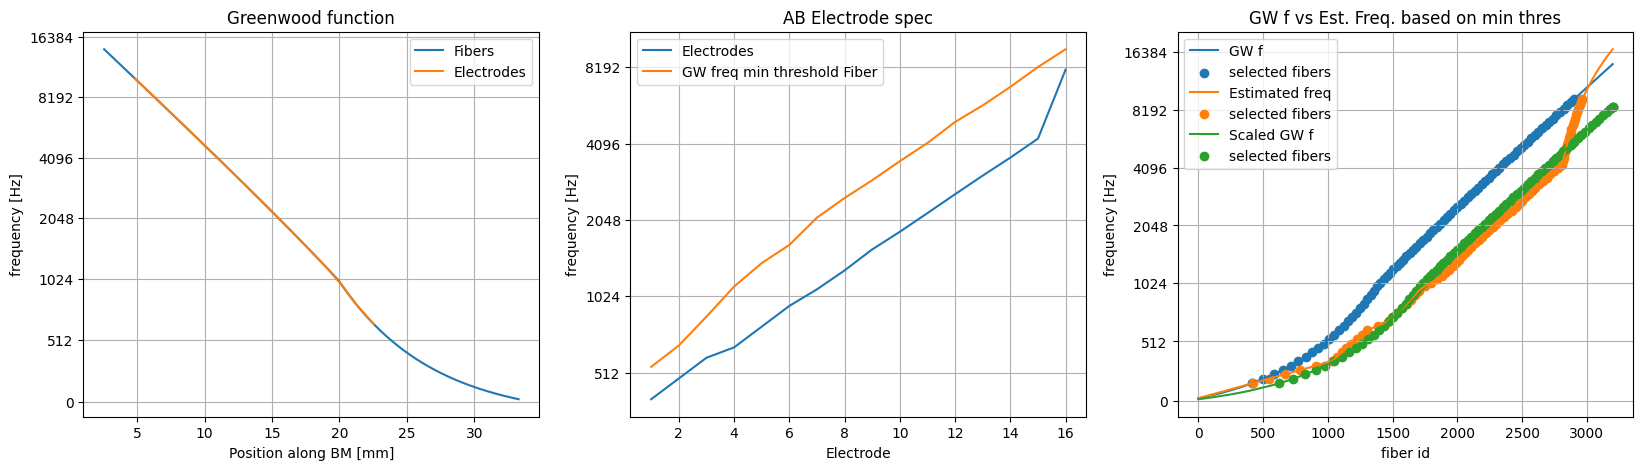

In [47]:
f, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(20, 5))

ax1.plot(MAT.mat['Df120']['Ln'][0], MAT.mat['Df120']['Fn'][0] * 1e3, label="Fibers")
ax1.plot(MAT.mat['Df120']['Le'][0], MAT.mat['Df120']['Fe'][0] * 1e3, label="Electrodes")
ax1.set_xlabel("Position along BM [mm]")
frequency_ax(ax1)
ax1.legend()
ax1.grid()
ax1.set_title("Greenwood function")

electrodes = np.arange(1, 17)
gwf_min_thresh = MAT.greenwood_f[np.argmin(MAT.I_det[:,::8], axis=0)]

ax2.plot(electrodes, ELECTRODE_FREQ_EDGES, label="Electrodes")
ax2.plot(electrodes, gwf_min_thresh, label="GW freq min threshold Fiber")


ax2.legend()
ax2.grid()
ax2.set_title("AB Electrode spec")
ax2.set_xlabel("Electrode")
frequency_ax(ax2)

# Remapping selected fibers
min_thresh_fiber_idx = np.argmin(MAT.I_det[:,::8], axis=0)

f = scipy.interpolate.interp1d(
    np.r_[0, min_thresh_fiber_idx], 
    np.r_[MAT.greenwood_f[0], ELECTRODE_FREQ_EDGES], 
    fill_value='extrapolate'
)

fidx = np.arange(0, 3200)
int_freq = f(fidx)

gwf = MAT.greenwood_f.copy()
gwf_scaled = gwf * .6

selected_fibers_gw = np.array([find_nearest_idx(gwf, val) for val in MEL_SCALE])
selected_fibers_gw_scaled = np.array([find_nearest_idx(gwf_scaled, val) for val in MEL_SCALE])
selected_fibers_est = np.array([find_nearest_idx(int_freq, val) for val in MEL_SCALE])

p = ax3.plot(fidx, gwf, label="GW f")
ax3.scatter(selected_fibers_gw, gwf[selected_fibers_gw], color=p[0].get_color(), label='selected fibers')
p = ax3.plot(fidx, f(fidx), label="Estimated freq")
ax3.scatter(selected_fibers_est, int_freq[selected_fibers_est], color=p[0].get_color(), label='selected fibers')

p = ax3.plot(fidx, gwf_scaled, label="Scaled GW f")
ax3.scatter(selected_fibers_gw_scaled, gwf_scaled[selected_fibers_gw_scaled], color=p[0].get_color(), label='selected fibers')


ax3.legend()
ax3.set_xlabel("fiber id")
frequency_ax(ax3)
ax3.grid()
ax3.set_title("GW f vs Est. Freq. based on min thres");

# Using estimated fibers
# selected_fibers = selected_fibers_est
# selected_fibers_freq = int_freq[selected_fibers]

# Using scaled Gw function
selected_fibers = selected_fibers_gw_scaled
selected_fibers_freq =  gwf_scaled[selected_fibers]

# Using original Gw function
# selected_fibers = selected_fibers_gw
# selected_fibers_freq =  gwf[selected_fibers]



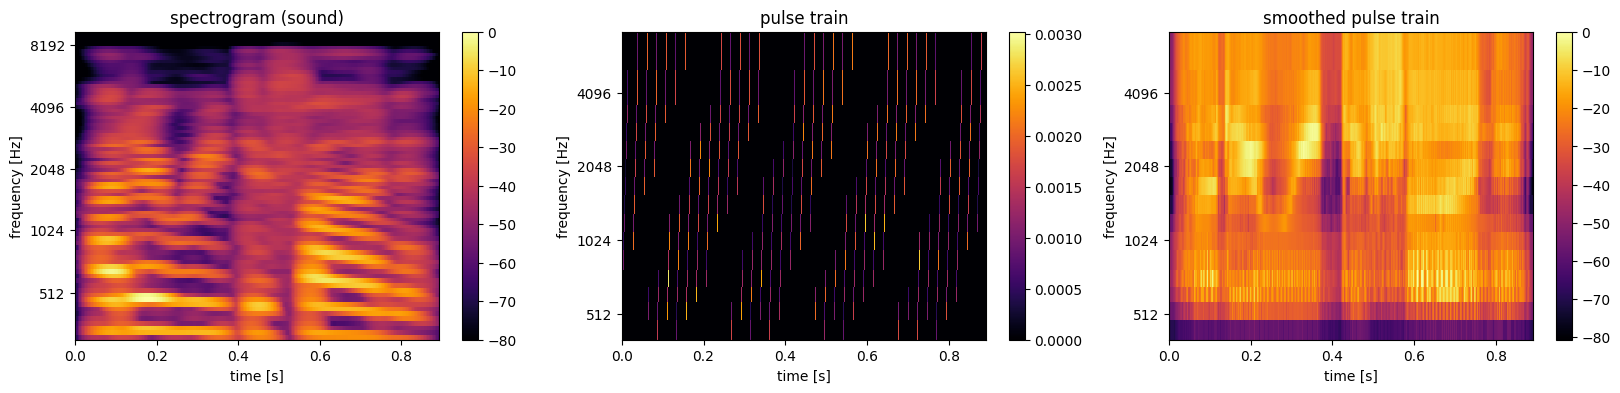

In [48]:
pdata = np.abs(pulse_train)
pdata = apply_filter(pdata, window_size=256, resample_to=pdata.shape[1], scale=True)

f, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(20, 4))

S_db = librosa.power_to_db(S, ref=np.max)
ts = np.linspace(0, duration, len(S_db[0]))

plot_heatmap(ts, MEL_SCALE, S_db, ax1, f)
ax1.set_title("spectrogram (sound)")

plot_heatmap(
    np.arange(pulse_train.shape[1]) * MAT.pw,
    ELECTRODE_FREQ_CENTERS,
    np.abs(pulse_train),
    ax=ax2,
    fig=f
)

ax2.set_title("pulse train")
plot_heatmap(
    np.arange(pulse_train.shape[1]) * MAT.pw,
    ELECTRODE_FREQ_CENTERS,
    pdata,
    ax=ax3,
    fig=f
)
ax3.set_title("smoothed pulse train");

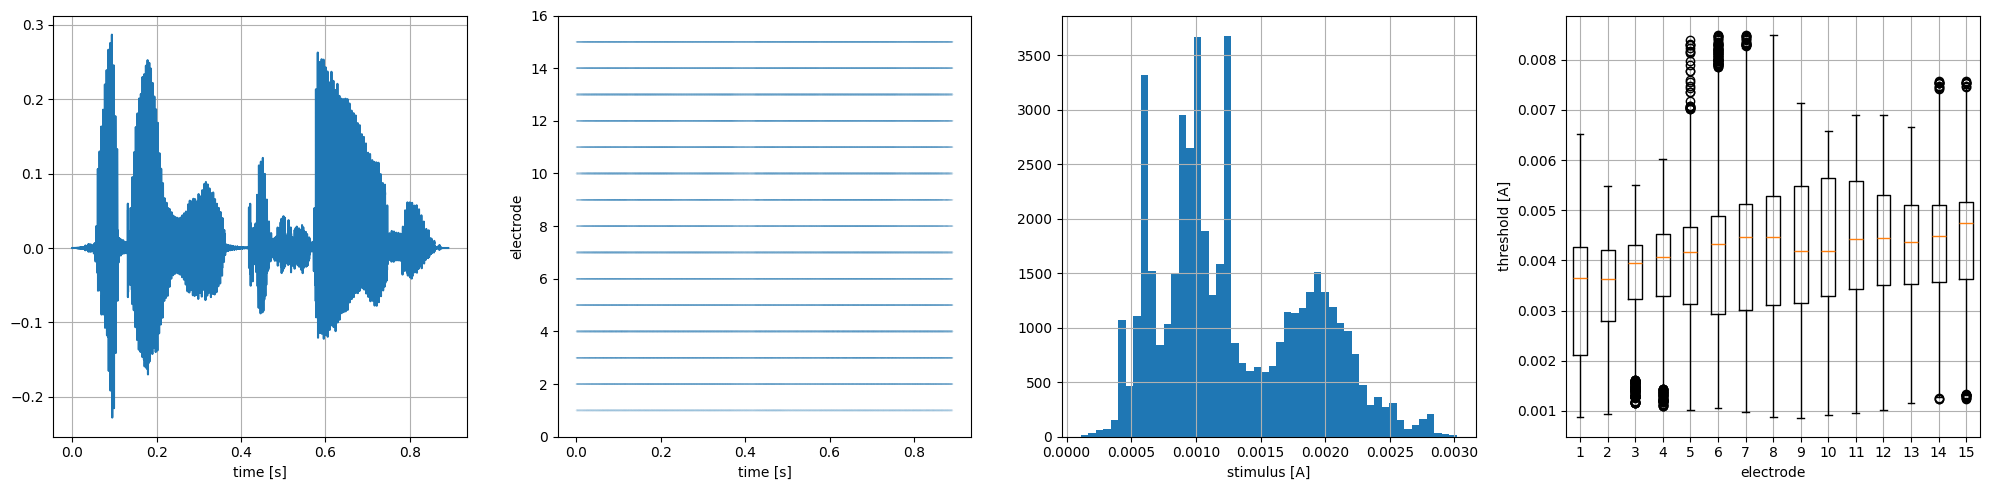

In [49]:
f, (ax1, ax2, ax3, ax4) = plt.subplots(1, 4,  figsize=(20, 5))

t_audio = np.arange(len(audio_signal)) * 1 / FS
ax1.plot(t_audio, audio_signal)
ax1.set_xlabel("time [s]")
ax1.grid()

e, t = np.where((pulse_train) > 0)
ax2.scatter(t * MAT.pw, e + 1, s=np.abs(pulse_train[e, t]))
ax2.set_ylim(1, pulse_train.shape[0])
ax2.set_xlabel("time [s]")
ax2.set_ylabel("electrode")
ax2.set_ylim(0, pulse_train.shape[0] + 1)

ax3.hist(np.abs(pulse_train[pulse_train > 0]), bins=50)
ax3.set_xlabel("stimulus [A]")
ax3.grid()

ax4.boxplot(IDET)
ax4.set_ylabel("threshold [A]")
ax4.set_xlabel("electrode")
ax4.grid()

plt.tight_layout()


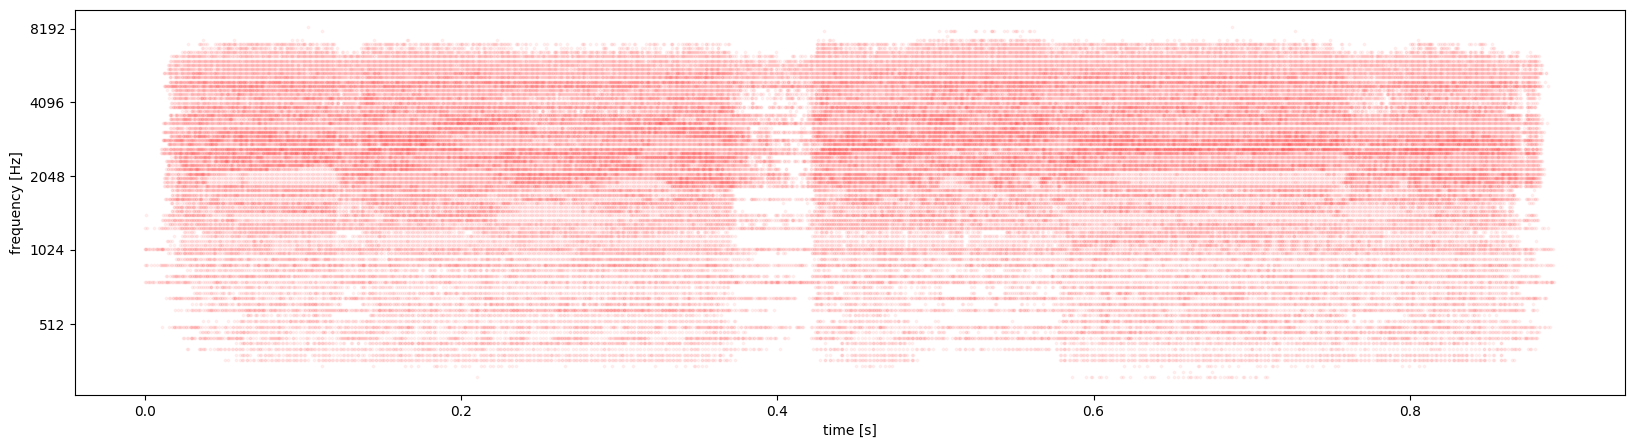

In [57]:
stimulus = phast.PulseTrain(pulse_train, time_step=MAT.pw)

decay = phast.LeakyIntegratorDecay(
    # accommodation_amplitude=0.072,
    # adaptation_amplitude=7.142,
    # accommodation_rate=0.014,
    # adaptation_rate=19.996
)

fibers = []
for fiber_idx in selected_fibers:
    fibers.append(
        phast.Fiber(
            i_det=IDET[fiber_idx],
            # spatial_constant=np.ones(IDET.shape[0]), 
            spatial_constant=MAT.spatial_factor(fiber_idx, IDET) * .1,
            sigma=MAT.sigma(fiber_idx, IDET),  
            fiber_id=fiber_idx,
            n_max=stimulus.n_pulses,  
            decay=decay,  
            store_stats=False,
        )
    )
    

fiber_stats = phast.phast(fibers, stimulus, generate_trials = 10, evaluate_in_parallel=True)

duration = stimulus.time_step * stimulus.t_max
binsize = 1e-5

neurogram = create_neurogram(fiber_stats, selected_fibers, binsize, duration)
del fiber_stats
import gc;gc.collect()

plt.figure(figsize=(20, 5))
for y in range(len(selected_fibers)):
    x = np.where(neurogram[y, :])[0]
    y = selected_fibers_freq[y]
    plt.scatter(x * binsize, y * np.ones(len(x)), color="red", alpha=.05, s=3)
    
time_vs_freq()


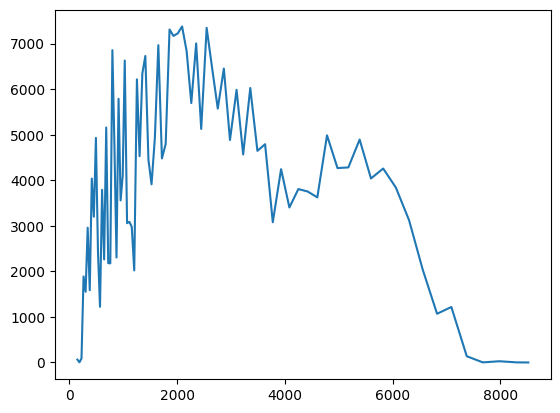

In [58]:
plt.plot(selected_fibers_freq, neurogram.sum(axis=1))

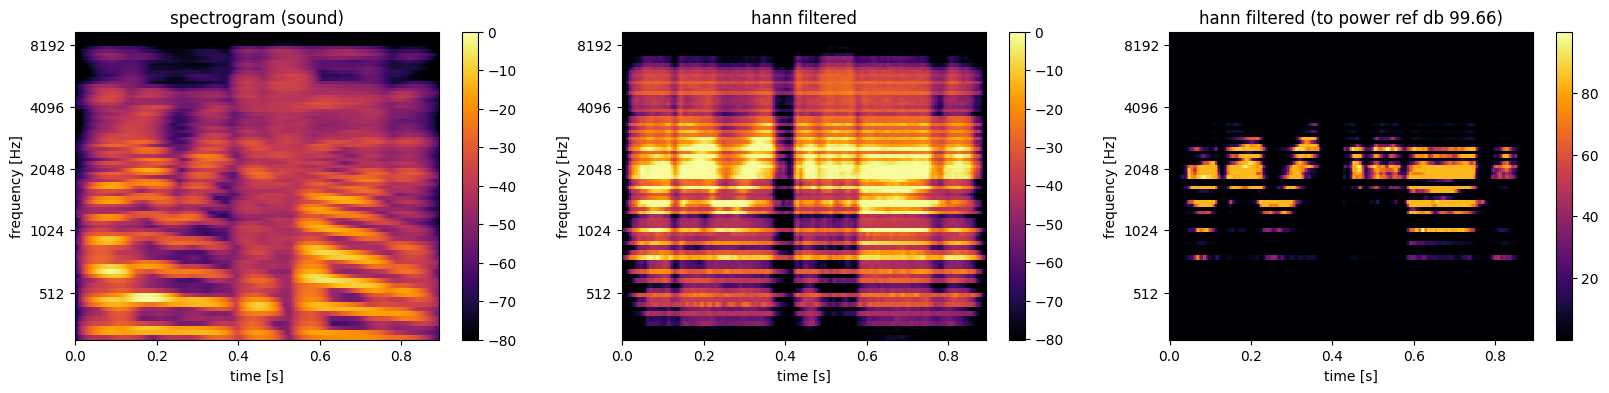

In [59]:
f, (ax0, ax1, ax2) = plt.subplots(1, 3, figsize=(20, 4))

plot_heatmap(ts, MEL_SCALE, S_db, ax0, f)
ax0.set_title("spectrogram (sound)")

filtered_data = apply_filter(neurogram, resample_to=S.shape[1])

t = np.linspace(0, duration, len(filtered_data[0]))
plot_heatmap(t, MEL_SCALE, filtered_data, ax=ax1, fig=f)
ax1.set_title("hann filtered")

ref_db = np.max(S)
mel_spec_ng = librosa.db_to_power(filtered_data, ref=ref_db)
plot_heatmap(t, MEL_SCALE, mel_spec_ng, ax=ax2, fig=f)
ax2.set_title(f"hann filtered (to power ref db {ref_db:.2f})");


In [60]:
mel_inversed = librosa.feature.inverse.mel_to_audio(mel_spec_ng,  n_fft=N_FFT, hop_length=N_HOP, sr=FS, fmin=MIN_FREQ, fmax=MAX_FREQ)

mel_inversed = scipy.signal.resample(mel_inversed, audio_signal.size)

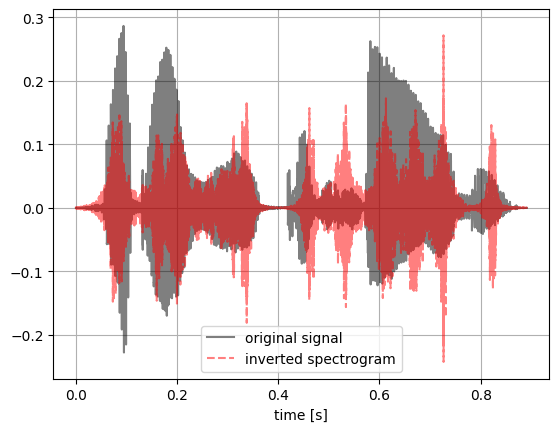

In [62]:
sc = (audio_signal.max() - audio_signal.min()) / (mel_inversed.max() - mel_inversed.min())
mel_inversed *= sc

t_audio = np.arange(len(audio_signal)) * 1 / FS
plt.plot(t_audio, audio_signal, label="original signal", color="black", alpha=.5)
plt.xlabel("time [s]")

t_mel = np.arange(len(mel_inversed)) * 1 / FS

plt.plot(
    t_mel, 
    mel_inversed,
    label="inverted spectrogram", 
    color ="red", 
    linestyle="dashed", 
    alpha=.5
)

mel_filt = scipy.signal.savgol_filter(mel_inversed, 64, 2) 
mel_filt *= (audio_signal.max() - audio_signal.min()) / (mel_filt.max() - mel_filt.min())

# plt.plot(
#     t_mel, mel_filt,
#     label="inverted spectrogram (filtered)", color ="blue", linestyle="dashed", alpha=.5
# )
plt.grid()
plt.legend()

sf.write(
    f"output/{NAME}.wav", audio_signal, FS, subtype='PCM_24'
)

sf.write(
    f"output/mel_reconstructed_{NAME}_filt.wav", mel_filt, FS, subtype='PCM_24'
)

sf.write(
    f"output/mel_reconstructed_{NAME}_ci.wav", mel_inversed, FS, subtype='PCM_24'
)


# n = int(np.ceil(mel_inversed.size * (16000 / FS)))
# mp3 = scipy.signal.resample(mel_inversed, n)
# sf.write(
#         f"output/mel_reconstructed_{NAME}_ci.mp3", mp3, 16000,
#         format='MP3', subtype='MPEG_LAYER_III'
# )




In [55]:
mel_inversed.size, audio_signal.size



(15507, 15507)

In [56]:
FS

17400